In [97]:
import os
import re
import json
import glob
import string
import datetime
from collections import Counter
import itertools
import pandas as pd
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import IPython.display
from IPython.display import display
# plt.rc('font', serif='Times New Roman', family='serif', size=12.0)

# Word processing

In [113]:
pg_stopwords_filepath = '/usr/local/Cellar/postgresql/9.6.1/share/postgresql/tsearch_data/english.stop'
pg_stopwords = set(line.strip() for line in open(pg_stopwords_filepath))
print '|pg_stopwords| =', len(pg_stopwords)

|pg_stopwords| = 127


In [112]:
nltk_stopwords_filepath = os.path.expanduser('~/nltk_data/corpora/stopwords/english')
nltk_stopwords = set(line.strip() for line in open(nltk_stopwords_filepath))
print '|nltk_stopwords| =', len(nltk_stopwords)

|nltk_stopwords| = 153


In [109]:
google_1t_stopwords = set(line.strip() for line in open('google-1t.txt'))
print '|google_1t_stopwords| =', len(google_1t_stopwords)

|google_1t_stopwords| = 193


In [110]:
alphabet = set(string.ascii_lowercase)
print '|alphabet| =', len(alphabet)

|alphabet| = 26


In [123]:
contraction_suffixes = set(['s', 'm', 're', 've', 'll', 'd', 't'])

In [182]:
standard_stopwords = google_1t_stopwords | contraction_suffixes

In [199]:
def tokenize(s, stopwords=None):
    # normalize abbreviations to avoid stranded initials
    s = re.sub(r'(?:[A-Z]\.)+', lambda m: m.group(0).replace('.', ''), s)
    # replace all non-alphanumerics with spaces
    s = re.sub(r'[^\w]', ' ', s)
    for token in s.lower().strip().split():
        if stopwords is None or token not in stopwords:
            yield token

In [200]:
def speeches_to_counts(speeches, stopwords=None):
    tokens = [token for speech in speeches for token in tokenize(speech['text'], stopwords)]
    return Counter(tokens)

In [201]:
def normalize_counts(counts, smoothing=0.0):
    total = float(sum(counts.values()))
    return {k: (v + smoothing) / total for k, v in counts.items()}

In [202]:
def read_lines(filepaths):
    for filepath in filepaths:
        with open(filepath) as fp:
            for line in fp:
                yield line

## Speech loading

In [139]:
def read_inaugural():
    for line in read_lines(['../data/tapp/inaugurals.json']):
        speech = json.loads(line)
        if 'Inaugural' in speech['title']:
            yield speech

In [140]:
pretrump_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
                                               if 'Trump' not in speech['author'])
print '# tokens:', sum(pretrump_inaugural_counts.values())

# tokens: 134797


In [141]:
# prewar_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
#                                              if speech['timestamp'] < '1948-11-01')
# print '# tokens:', sum(prewar_inaugural_counts.values())

In [142]:
postwar_pretrump_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
                                                       if speech['timestamp'] > '1948-11-01' 
                                                       and 'Trump' not in speech['author'])
print '# tokens:', sum(postwar_pretrump_inaugural_counts.values())
# print 'top 50 types:', postwar_pretrump_inaugural_counts.most_common(50)

# tokens: 33938


In [143]:
def read_election2016_speeches():
    for line in read_lines(['../data/tapp/election2016.json']):
        speech = json.loads(line)
        title = speech['title']
        if 'Press Release' not in title and 'Statement by' not in title:
            yield speech

In [145]:
trump_election2016_counts = speeches_to_counts(speech for speech in read_election2016_speeches()
                                               if speech['author'] == 'Donald J. Trump')
print '# tokens:', sum(trump_election2016_counts.values())
# print 'top 50 types:', trump_election2016_counts.most_common(50)

# tokens: 163681


# Proportion of speech allocated to specific word groups

In [146]:
synsets = [
    ('freedom(s)', ['freedom', 'freedoms']),
    ('justice', ['justice']),
    ('liberty(ies)', ['liberty', 'liberties']),
    ('rights', ['rights']),
    ('america(n/s)', ['america', 'americans', 'american']),
    ('job(s)', ['job', 'jobs']),
]

In [147]:
def proportional_usage(tokens, counts):
    maximum = sum(counts.values())
    usage = sum(counts.get(token, 0) for token in tokens)
    return float(usage) / float(maximum)

def synset_proportional_usages(synsets, counts):
    return {synset_name: proportional_usage(synset_tokens, counts) for synset_name, synset_tokens in synsets}

In [152]:
def iter_usages():
    sources = [('All pre-Trump inaugural speeches', pretrump_inaugural_counts),
               #('Pre-war inaugural speeches', prewar_inaugural_counts),
               ('Post-war, pre-Trump inaugural speeches', postwar_pretrump_inaugural_counts),
               ('Trump campaign speeches', trump_election2016_counts)]
    for source_name, source_counts in sources:
        for synset_name, synset_tokens in synsets:
            usage = proportional_usage(synset_tokens, source_counts)
            yield dict(source=source_name, synset=synset_name, usage=usage)

In [153]:
df_usages = pd.DataFrame.from_dict(iter_usages())

In [154]:
df_usages_t = df_usages.pivot(index='synset', columns='source', values='usage')
df_usages_t

source,All pre-Trump inaugural speeches,"Post-war, pre-Trump inaugural speeches",Trump campaign speeches
synset,,,
america(n/s),0.003145,0.007838,0.010154
freedom(s),0.001417,0.003683,0.000128
job(s),0.000096,0.000354,0.004515
justice,0.001016,0.001149,0.000403
liberty(ies),0.001002,0.001355,0.000079
rights,0.001024,0.000648,0.000147


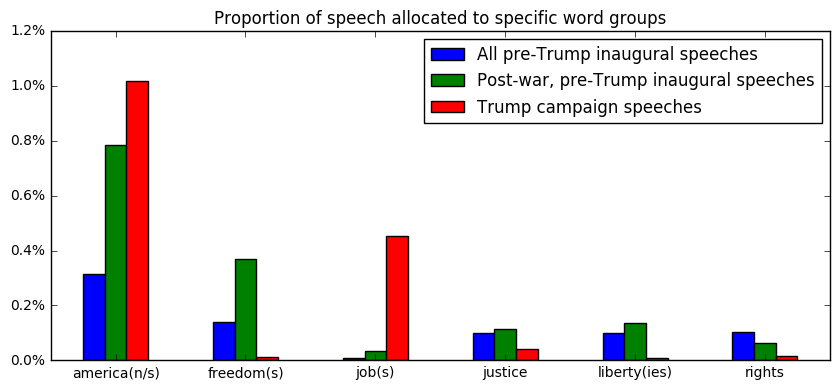

In [155]:
ax = df_usages_t.plot(figsize=(8.5, 4), kind='bar')
ax.xaxis.label.set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.01%}'.format(y))) 
legend = ax.legend()
legend.set_title(None)
plt.xticks(rotation=0)
plt.title('Proportion of speech allocated to specific word groups')
plt.tight_layout()
# plt.savefig('grouped_proportions.nostopwords.pdf')

# Inaugural address word count

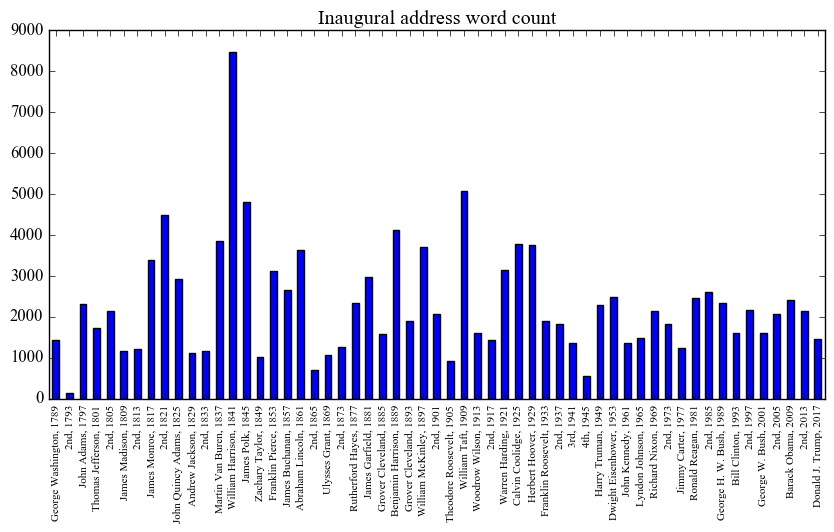

In [680]:
ordinal_mapping = {'First': '1st', 'Second': '2nd', 'Third': '3rd', 'Fourth': '4th'}
def get_inaugural_ticklabels(df):
    last_author = None
    for _, speech in df.iterrows():
        author = speech.author
        title = ordinal_mapping[speech.title.split()[0]] if author == last_author else author
        last_author = author
        yield title + ', ' + str(speech.timestamp.year)
# draw plot for all inaugurals
ax = df.plot(x='timestamp', y='word_count', figsize=(8.5, 5.5), kind='bar', legend=False, 
             title="Inaugural address word count")
ticklabels = list(get_inaugural_ticklabels(df))
for label in ax.get_xticklabels():
    label.set_fontsize(8)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig('inaugural_word_count.pdf')

# Surname mentions in inaugural speechs

In [30]:
inaugural_speeches = list(read_inaugural())

In [44]:
surnames = set([speech['author'].split()[-1] for speech in inaugural_speeches])

In [45]:
def iter_speech_surname_count():
    for speech in inaugural_speeches:
        text = speech['text']
        for surname in surnames:
            yield speech, surname, text.count(surname)

In [50]:
def iter_surnames():
    for speech, surname, count in iter_speech_surname_count():
        title = speech['author'] + ': ' + speech['title']
        yield dict(title=title, surname=surname, count=count)

In [74]:
df_surnames = pd.DataFrame.from_dict(iter_surnames())
df_surnames[:10]

,count,surname,title
0,0,Wilson,Barack Obama: Inaugural Address
1,0,Coolidge,Barack Obama: Inaugural Address
2,0,Grant,Barack Obama: Inaugural Address
3,0,Washington,Barack Obama: Inaugural Address
4,0,Pierce,Barack Obama: Inaugural Address
5,0,Trump,Barack Obama: Inaugural Address
6,1,Bush,Barack Obama: Inaugural Address
7,0,Jefferson,Barack Obama: Inaugural Address
8,0,Jackson,Barack Obama: Inaugural Address
9,0,Hoover,Barack Obama: Inaugural Address


In [70]:
df_xtab = df_surnames.pivot(index='title', columns='surname', values='count')
# df_xtab

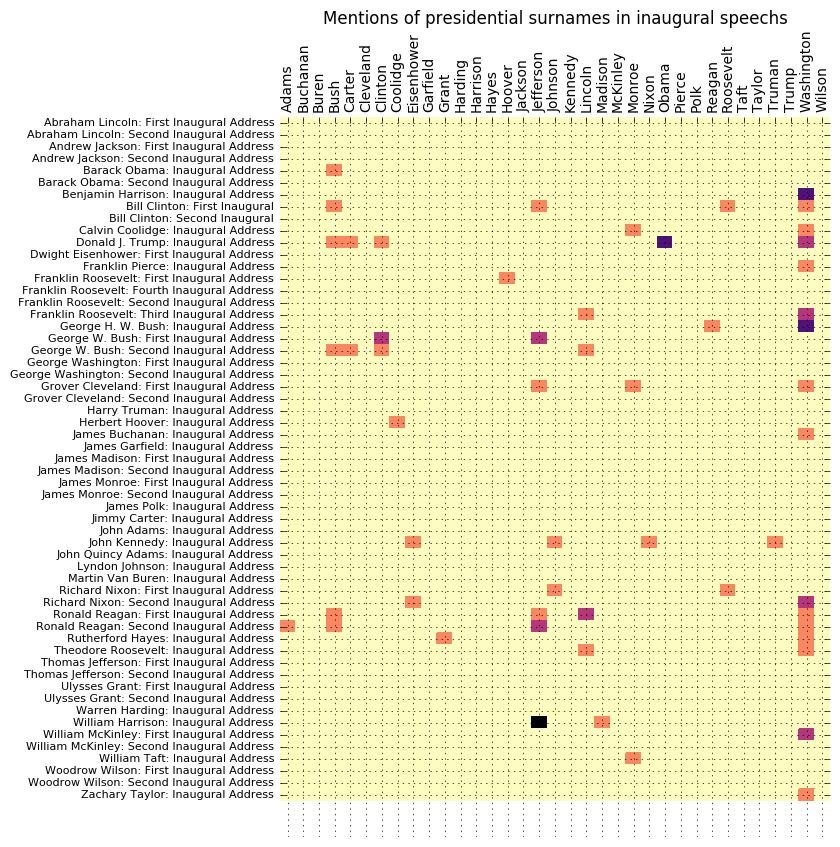

In [98]:
# based on https://stackoverflow.com/a/16124677
plt.figure(figsize=(8.5, 8.5))
plt.pcolor(df_xtab, cmap=plt.cm.magma_r)
ax = plt.axes()
ax.set_frame_on(False)
ax.set_yticks(np.arange(df_xtab.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(df_xtab.shape[1]) + 0.5, minor=False)
# flip x-ticks/labels to top
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
# ax.xaxis.tick_top()
plt.xticks(rotation=90)
# set the x/y tick labels
ax.set_xticklabels(df_xtab.columns, minor=False)
ax.set_yticklabels(df_xtab.index, minor=False)
ax.grid(True)
# better label fit
for label in ax.get_yticklabels():
    label.set_fontsize(8)
plt.title('Mentions of presidential surnames in inaugural speechs', y=1.12)
plt.tight_layout()
# plt.savefig('inaugural_surnames.pdf')

# Significant others

In [264]:
pd.options.display.max_rows = 10

In [265]:
pretrump_inaugural_counts = speeches_to_counts(
    (speech for speech in read_inaugural() 
     if 'Trump' not in speech['author']), standard_stopwords)
print '|tokens| =', sum(pretrump_inaugural_counts.values())

|tokens| = 58329


In [266]:
trump_election2016_counts = speeches_to_counts(
    (speech for speech in read_election2016_speeches()
     if speech['author'] == 'Donald J. Trump'), standard_stopwords)
print '|tokens| =', sum(trump_election2016_counts.values())

|tokens| = 73848


In [267]:
hillary_election2016_counts = speeches_to_counts(
    (speech for speech in read_election2016_speeches()
     if speech['author'] == 'Hillary Clinton'), standard_stopwords)
print '|tokens| =', sum(hillary_election2016_counts.values())

|tokens| = 412256


In [268]:
groups = [('inaugural', pretrump_inaugural_counts),
          ('hillary', hillary_election2016_counts),
          ('trump', trump_election2016_counts)]
vocab = set([token for _, counts in groups for token in counts.keys()])
print '|vocab| =', len(vocab)

|vocab| = 23912


In [269]:
def iter_counts(smoothing=0):
    for group_name, group_counts in groups:
        for word in vocab:
            yield dict(group=group_name, word=word, word_count=group_counts.get(word, 0) + smoothing)

In [270]:
def set_proportion(df):
    '''This seems ugly, but it works'''
    df['proportion'] = df['word_count'] / np.sum(df['word_count'])
    return df

In [275]:
df_counts = pd.DataFrame.from_dict(iter_counts(1.0)).sort_values('word_count', ascending=False)
df_counts = df_counts.groupby('group').apply(set_proportion).sort_values('proportion', ascending=False)
df_counts

,group,word,word_count,proportion
30008,hillary,people,4007.0,0.009187
53920,trump,people,876.0,0.008961
60672,trump,clinton,860.0,0.008797
59871,trump,country,845.0,0.008644
50088,trump,american,818.0,0.008367
...,...,...,...,...
45990,hillary,happiest,1.0,0.000002
33445,hillary,disloyalty,1.0,0.000002
40565,hillary,splendor,1.0,0.000002
40564,hillary,intolerant,1.0,0.000002


In [274]:
# k = 250
# df_proportions_top_k = df_proportions.groupby('group').head(k) # or .nlargest(k) ?

In [254]:
# df_counts_pivot = df_counts.pivot(index='word', columns='group')
# df_proportions = df_counts_pivot['proportion']
# df_proportions.ix[:, 'word_count'] = df_counts_pivot['word_count'].sum(axis=1)
# df_proportions

In [276]:
df_proportions = df_counts.pivot(index='word', columns='group', values='proportion')
df_proportions

group,hillary,inaugural,trump
word,,,
0,0.000037,0.000012,0.000051
00,0.000078,0.000012,0.000020
000,0.001332,0.000170,0.002005
00002,0.000005,0.000012,0.000010
007419,0.000005,0.000012,0.000010
...,...,...,...
zones,0.000030,0.000012,0.000061
zquez,0.000007,0.000012,0.000010
zuberi,0.000005,0.000012,0.000010


In [277]:
pd.options.display.max_rows = 20

In [278]:
df_proportions_t['trump/inaugural'] = df_proportions_t.trump / df_proportions_t.inaugural
df_proportions_t['hillary/inaugural'] = df_proportions_t.hillary / df_proportions_t.inaugural
df_proportions_t['trump/hillary'] = df_proportions_t.trump / df_proportions_t.hillary

In [279]:
df_proportions_t.sort_values('trump/inaugural')

group,hillary,inaugural,trump,trump/inaugural,hillary/inaugural,trump/hillary
word,,,,,,
countrymen,0.000002,0.000669,0.000010,0.015296,0.003428,4.461620
union,0.000605,0.002298,0.000041,0.017804,0.263376,0.067600
duties,0.000014,0.001131,0.000020,0.018091,0.012165,1.487207
exercise,0.000078,0.000523,0.000010,0.019564,0.149089,0.131224
peoples,0.000025,0.000511,0.000010,0.020030,0.049383,0.405602
blessings,0.000030,0.000499,0.000010,0.020518,0.059785,0.343202
faithful,0.000021,0.000450,0.000010,0.022737,0.045864,0.495736
object,0.000011,0.000450,0.000010,0.022737,0.025480,0.892324
solemn,0.000021,0.000426,0.000010,0.024036,0.048485,0.495736


In [280]:
df_proportions_t.sort_values('hillary/inaugural')

group,hillary,inaugural,trump,trump/inaugural,hillary/inaugural,trump/hillary
word,,,,,,
countrymen,0.000002,0.000669,0.000010,0.015296,0.003428,4.461620
mankind,0.000002,0.000523,0.000031,0.058692,0.004385,13.384861
intercourse,0.000002,0.000316,0.000010,0.032356,0.007252,4.461620
confederacy,0.000002,0.000243,0.000010,0.042063,0.009428,4.461620
instrument,0.000005,0.000413,0.000020,0.049486,0.011091,4.461620
practicable,0.000002,0.000207,0.000010,0.049486,0.011091,4.461620
objects,0.000005,0.000389,0.000031,0.078868,0.011785,6.692430
controversies,0.000002,0.000195,0.000010,0.052578,0.011785,4.461620
continuance,0.000002,0.000195,0.000010,0.052578,0.011785,4.461620


In [281]:
df_proportions_t.sort_values('trump/hillary')

group,hillary,inaugural,trump,trump/inaugural,hillary/inaugural,trump/hillary
word,,,,,,
activist,0.000692,0.000012,0.000010,0.841254,56.943155,0.014774
mortgage,0.000498,0.000012,0.000010,0.841254,40.916108,0.020560
mccain,0.000452,0.000012,0.000010,0.841254,37.145038,0.022648
choices,0.000436,0.000085,0.000010,0.120179,5.117881,0.023482
retirement,0.000777,0.000097,0.000020,0.210314,7.989954,0.026322
mortgages,0.000371,0.000012,0.000010,0.841254,30.545666,0.027541
invisible,0.000355,0.000024,0.000010,0.420627,14.612896,0.028785
senator,0.002779,0.000134,0.000082,0.611821,20.775167,0.029450
autism,0.000344,0.000012,0.000010,0.841254,28.283024,0.029744
